# Training and evaluation of modified IM2ELEVATION model

In [1]:
# Ensures runtime code is updated when source code of libraries are updated as well
%load_ext autoreload
%autoreload 2

In [2]:
# Import of necessary libraries

import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import numpy as np
import pickle
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import ssl

from osgeo import gdal
import geopandas as gpd

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# FastAI
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

import utils.data_utils as du
import utils.sp_utils as sp



In [3]:
# User modules

from utils.models import senet
from utils.models import modules
from utils.models import net

In [4]:
# Check if gpu/cuda is available
import torch
torch.cuda.is_available()

True

In [5]:
# Constants
CHECKPT_PATH = "pretrained_model/im2elevation/Block0_skip_model_110.pth.tar"


## Build Dataset

In [6]:
class UMPDataset(Dataset):
    """Urban Morphological Parameters - Sentinel Dataset"""

    def __init__(self, ump_df, dir_path, file_ext= ".tiff", transform= None):
        """
        # Parameters:
            - ump_df: DataFrame containing the geometry of each cell with its corresponding UMPs.
            - dir_path: Directory in which all tiff files will be matched with it's corresponding cells in ump_df.
                - No trailing slashes for dir. eg. "data/osaka"
                - Naming convention for files: Sentinel_{'_'.join(map(str, map(int, cell.bounds)))}.tiff for cell in ump_df["geometry"]
            - file_ext: Extension of the file eg. .tiff / .tif
        """
        self.ump_df = ump_df
        self.dir_path = dir_path
        self.file_ext = file_ext
        # Look in both current and sub-directories
        self.files = glob.glob(f"{self.dir_path}/**/*{self.file_ext}") + glob.glob(f"{self.dir_path}/*{self.file_ext}")
        self.transform = transform

        # Generate the max and min for each channel as well
        self.channel_max = [0 for _ in range(12)]
        for i in range(len(self)):
            for entry in self[i]:
                # The image
                for channel in range(len(entry)):
                    cur_max = entry[channel].max()
                    if cur_max > self.channel_max[channel]:
                        self.channel_max[channel] = cur_max
    
    def __len__(self):
        return len(self.ump_df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        poly = self.ump_df["geometry"][idx]
        target = f"Sentinel_{'_'.join(map(str, map(int, poly.bounds)))}.tiff"
        # Finds and return the first match in a string
        file_name = next((s for s in self.files if target in s), None)
        if file_name is None:
            raise KeyError(f"{target} not found in {self.dir_path}")
        
        image = gdal.Open(file_name, gdal.GA_ReadOnly).ReadAsArray()

        if image.shape != (12, 90, 90):
            print("Non-standard image shape:", image.shape)
            if image.shape[0] != 12:
                raise ValueError(f"Incorrect number of channels, {image.shape[0]} channels present when 12 expected")
            

        umps = list(self.ump_df.iloc[idx][[
            "AverageHeightArea", 
            "AverageHeightBuilding", 
            "AverageHeightTotalArea", 
            "Displacement", 
            "FrontalAreaIndex",
            "MaximumHeight",
            "PercentileHeight",
            "PlanarAreaIndex",
            "RoughnessLength",
            "StandardDeviation",
        ]])

        out = [image, umps]

        if self.transform:
            out = self.transform(out)
        
        return out
        



In [7]:
Y_tokyo = gpd.read_feather("data/Y_UMP/Y_tokyo_4.feather")
ds_tokyo = UMPDataset(Y_tokyo, "data/X_sentinel/tokyo")

In [8]:
Y_osaka = gpd.read_feather("data/Y_UMP/Y_osaka_4.feather")
ds_osaka = UMPDataset(Y_osaka, "data/X_sentinel/osaka")

### Visualisation Functions

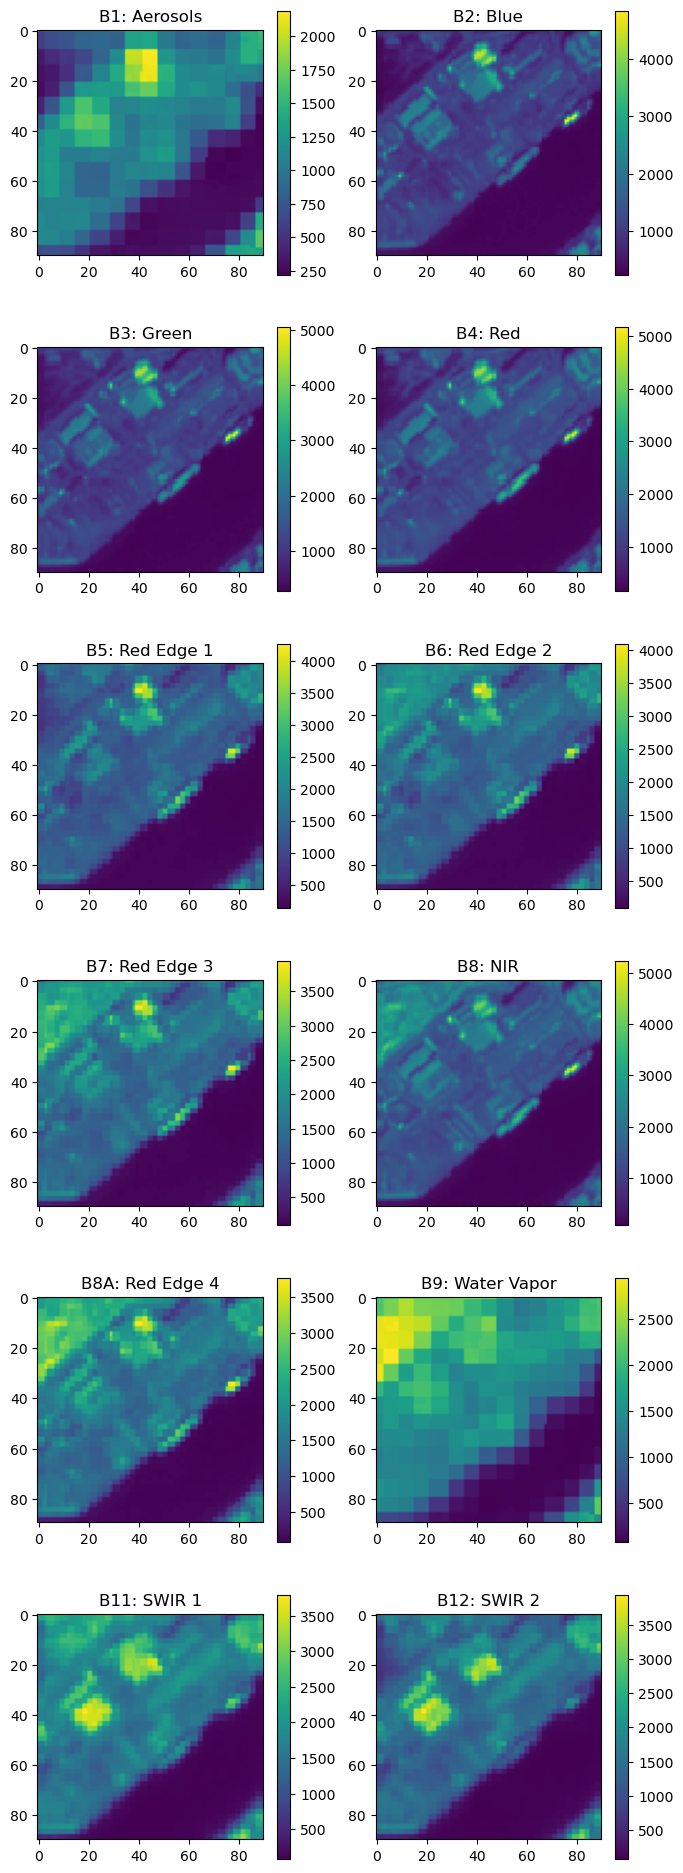

In [9]:
du.plotArray(ds_osaka[0][0])

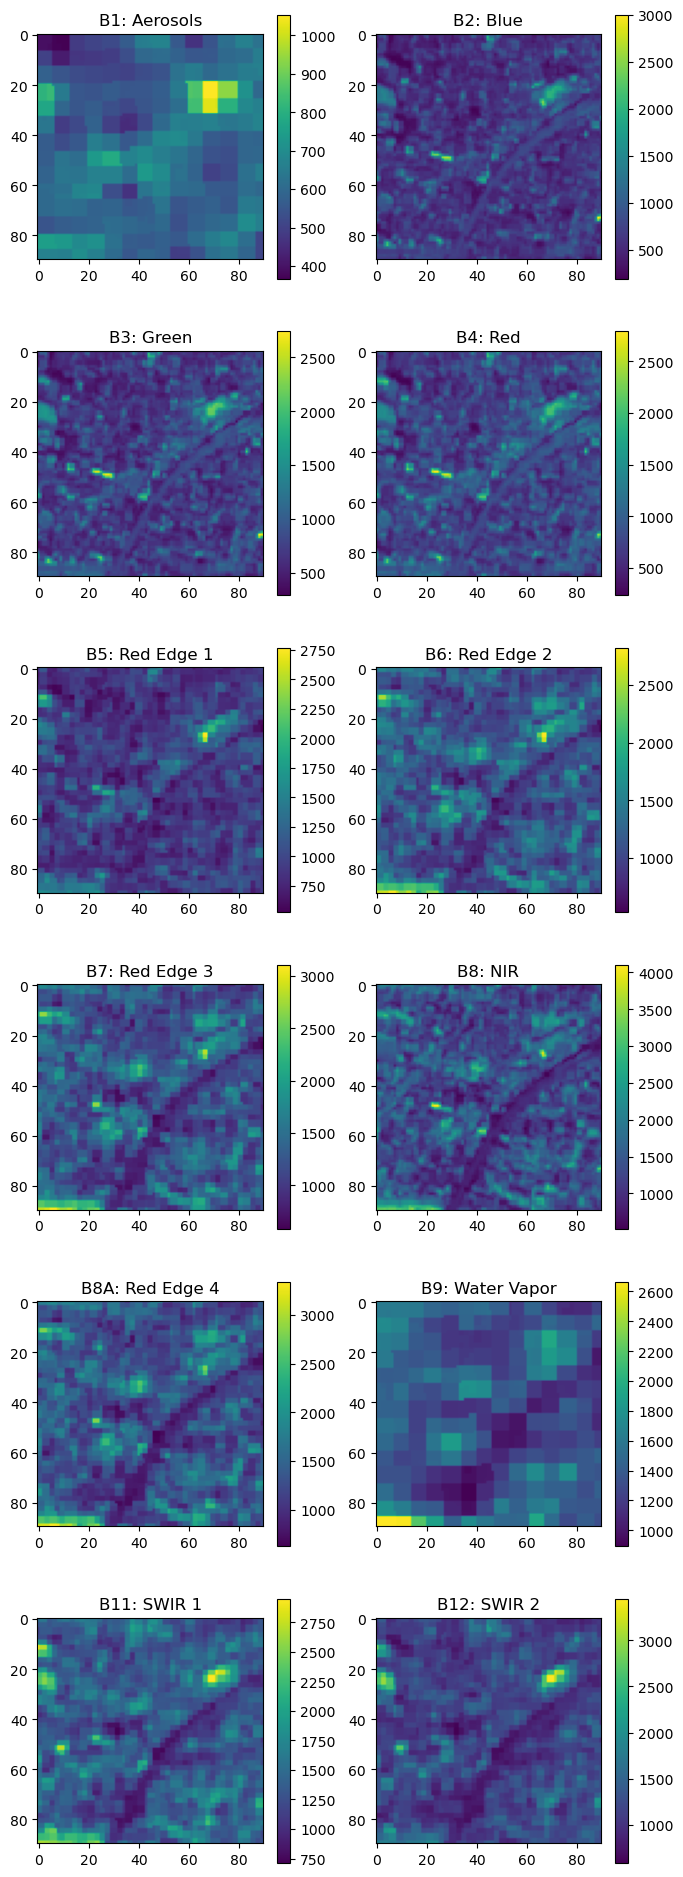

In [10]:
du.plotArray(ds_tokyo[0][0])

### Check dataset

In [11]:
len(ds_osaka), len(ds_tokyo)

(1145, 3286)

In [12]:
# Check for shape discrepancies
for i in range(len(ds_osaka)):
    ds_osaka[i]

In [13]:
# Check for shape discrepancies
for i in range(len(ds_tokyo)):
    ds_tokyo[i]

### Create FastAI dataloaders

In [14]:
dl = DataLoaders().from_dsets(ds_tokyo, ds_osaka, bs= 8, device=torch.device('cuda'))

#### Validate the shape and len

In [15]:
# Check that dimensions are right
test_batch = dl.one_batch()

In [36]:
# Validate shape
test_batch[0].shape, torch.stack(test_batch[1], dim= 1).shape

(torch.Size([8, 12, 90, 90]), torch.Size([8, 10]))

In [16]:
# Validate len
len(dl.train_ds), len(dl.valid_ds)

(3286, 1145)

## Training the Model

### Extract the max for normalisation

In [22]:
dl.train_ds

In [39]:
[max(channel) for channel in dl.train_ds]

### Model using custom weights (12 channels)
- Using weights from previous model
- Expand model to accept 12 channels instead of just 3

In [ ]:
# Load weights from IM2ELEVATION and delete unnecessary layers
checkpoint = torch.load(CHECKPT_PATH)

to_delete = []
for layer in checkpoint["state_dict"].keys():
    if any([word in layer.upper() for word in ["HARM", "R.CONV4", "R.BN4"]]):
    # if any([word in layer.upper() for word in ["HARM", "R.CONV3", "R.BN3", "R.CONV4", "R.BN4"]]):
        to_delete.append(layer)
print(to_delete)

for i in to_delete:
    checkpoint["state_dict"].pop(i)

# Load Weights
ssl._create_default_https_context = ssl._create_unverified_context

original_model = senet.senet154()

Encoder = modules.E_senet(original_model, x_norms)
model = net.model(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])

# Load trimmed im2elevation weights
model.load_state_dict(checkpoint["state_dict"], strict=False)

# Clear memory
del checkpoint
gc.collect()
torch.cuda.empty_cache()

['E.Harm.dct', 'E.Harm.weight', 'E.Harm.bias', 'R.conv4.weight', 'R.conv4.bias']


#### Merging the channels

To merge the channels, the inputs are put to run in parallel until around the mid-way point of the senet backbone, before merging them...?

In [ ]:
model = net.model_n12(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])
# merged_model = convert_network(model, torch.float16)

### Check Model Sanity

In [38]:
test_batch = dl.one_batch()[0]
test_batch.shape

torch.Size([8, 12, 90, 90])

In [ ]:
test_batch_2 = tensor(np.array([i[0] for i in dl.train_ds]))
test_batch_2_y = tensor(np.array([i[1] for i in dl.train_ds]))

In [ ]:
merged_model.eval()
merged_model.cuda()
merged_model(test_batch).shape

torch.Size([8, 8])

In [ ]:
# Load problem x?
with open("logs/x1.pkl", "rb") as f:
    x = pickle.load(f)

merged_model.eval()
merged_model(x.cpu())

TensorBase([[ 0.1637,  0.0986, -0.0395, -0.0691, -0.1730, -0.0662,  0.1068,
             -0.0262],
            [ 0.1629,  0.0980, -0.0387, -0.0688, -0.1735, -0.0651,  0.1064,
             -0.0262],
            [ 0.1625,  0.0976, -0.0398, -0.0704, -0.1745, -0.0644,  0.1049,
             -0.0236],
            [ 0.1627,  0.0977, -0.0391, -0.0691, -0.1742, -0.0650,  0.1060,
             -0.0266],
            [ 0.1646,  0.0997, -0.0388, -0.0676, -0.1723, -0.0670,  0.1077,
             -0.0278],
            [ 0.1637,  0.0982, -0.0393, -0.0689, -0.1729, -0.0658,  0.1071,
             -0.0262],
            [ 0.1637,  0.0986, -0.0390, -0.0686, -0.1733, -0.0666,  0.1072,
             -0.0268],
            [ 0.1638,  0.0989, -0.0391, -0.0683, -0.1729, -0.0663,  0.1072,
             -0.0267]], grad_fn=<AliasBackward0>)

In [ ]:
merged_model.eval()
merged_model.cuda()
for batch in range(0, len(test_batch_2), 8):
    preds = merged_model(test_batch_2[batch:min(batch+8, len(test_batch_2))].cuda())
    if mse_weighted(preds, test_batch_2_y[batch:min(batch+8, len(test_batch_2))].cuda()).isnan().sum() > 0:
        print(batch)
        break

In [ ]:
merged_model.cuda()
merged_model(tensor(dls_12.train_ds[0][0]).unsqueeze(0).cuda()).shape

In [ ]:
merged_model.cuda()
for i in dls_12.train_ds:
    if merged_model(tensor(i[0]).unsqueeze(0).cuda()).isnan().sum() > 0:
        print(i)
        print(merged_model(i[0]))
        break

### Train Model

In [ ]:
# Need better loss due to scale difference
# learn = Learner(dls_12, merged_model, loss_func= mse_weighted, metrics= metrics)
learn = Learner(dls_12, model, loss_func= mse_weighted, metrics= metrics, cbs=[MixedPrecision, FP16TestCallback])

SuggestedLRs(valley=0.00019054606673307717)

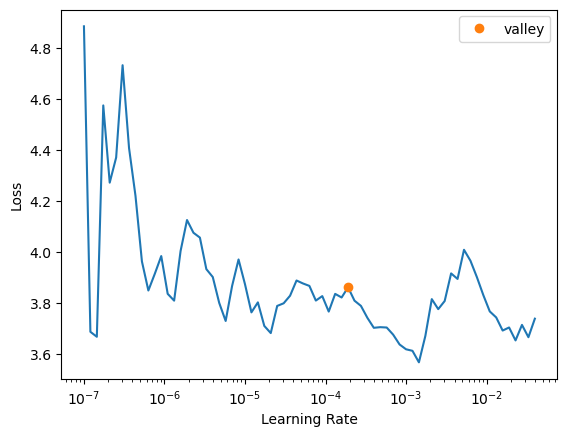

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,height_avg_bld_rmse,height_avg_area_rmse,height_avg_total_rmse,height_std_rmse,height_max_rmse,height_percentile_rmse,planar_index_rmse,frontal_index_rmse,time
0,1.366890,10.218493,10.232885,18.338076,4.710033,22232.190308,61.842902,31.304233,0.866774,0.653567,03:52


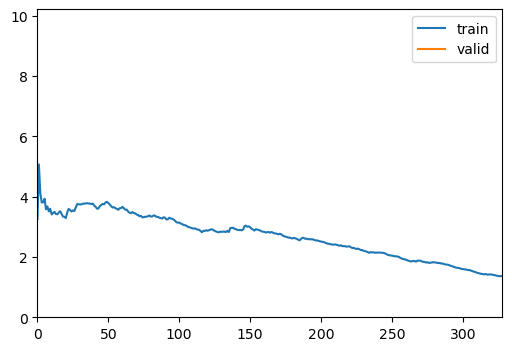

epoch,train_loss,valid_loss,height_avg_bld_rmse,height_avg_area_rmse,height_avg_total_rmse,height_std_rmse,height_max_rmse,height_percentile_rmse,planar_index_rmse,frontal_index_rmse,time
0,0.778249,11.822211,8.884027,18.450155,6.357875,22233.167346,66.581416,31.898599,1.009521,0.284990,03:51
1,0.524141,605.975403,67.982162,112.815763,67.829097,22183.809798,262.406007,22.610498,5.147591,5.221504,03:47
2,0.364647,0.640605,4.612198,9.508872,2.341330,22233.867696,50.291545,18.732041,0.244909,0.278933,03:40
3,0.273929,0.957175,2.843286,7.001287,3.109090,22234.065890,47.482666,15.221525,0.350471,0.373566,03:38
4,0.194661,0.060562,3.064444,5.961215,2.700709,22234.670347,37.714363,11.451646,0.069642,0.077121,03:35
5,0.158377,0.162754,3.312829,5.408717,2.510564,22234.384211,34.030744,9.736979,0.134499,0.180734,03:33
6,0.138168,0.063264,3.440298,6.798230,1.965048,22234.195450,29.410552,9.381919,0.067451,0.103340,03:32
7,0.122031,0.053639,2.410338,5.155369,1.342771,22234.332191,27.439098,7.963607,0.061748,0.120119,03:33
8,0.098311,0.057761,4.689662,10.487348,2.172056,22233.790546,23.652226,17.361254,0.055470,0.085459,03:35
9,0.099431,0.131000,5.448552,13.292404,1.560960,22232.632420,27.466056,22.370687,0.090981,0.086416,03:34


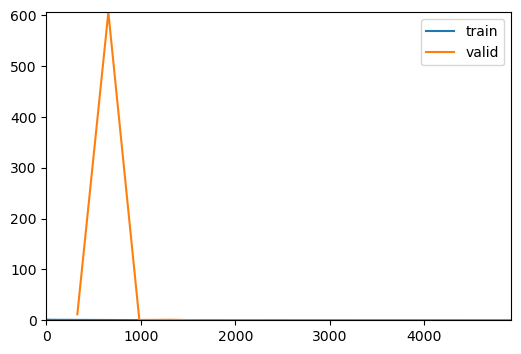

In [ ]:
learn.fine_tune(15, 0.001, cbs= [ShowGraphCallback()])